#### Working with many molecules¶

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, PandasTools, Descriptors, Draw
import pandas as pd
#import ipywidgets

In [2]:
df = pd.read_csv("../data/EGFR-course.csv", names=["Smiles", "Name"], header=None)
df

,Smiles,Name
0,COCCOc1cc2c(cc1OCCOC)ncnc2Nc3cccc(c3)C#C,Erlotinib
1,COC1CCN(CC1)c1nccc(Nc2cc3n(ccc3cn2)C2CCCC2)n1,3QS_4rj3
2,CC(C)(O)CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc(c4)...,03P_3poz
3,Nc1ncnc2n(cnc12)[C@@H]1O[C@H](CO[P@@](O)(=O)O[...,ANP_5cno
4,OCCNC(=O)C1=Cc2c(Nc3ccc(Oc4cccc5sccc45)c(Cl)c3...,W19_3w33
5,OCCOCCn1ccc2ncnc(Nc3ccc(Oc4cccc(NC(=O)NC5CCCCC...,W2R_3w2s


In [3]:
df.columns

Index(['Smiles', 'Name'], dtype='object')

In [4]:
df.shape

(6, 2)

In [5]:
smiles = df.Smiles.tolist()
names = df.Name.tolist()

print(smiles[0], names[0])

COCCOc1cc2c(cc1OCCOC)ncnc2Nc3cccc(c3)C#C Erlotinib


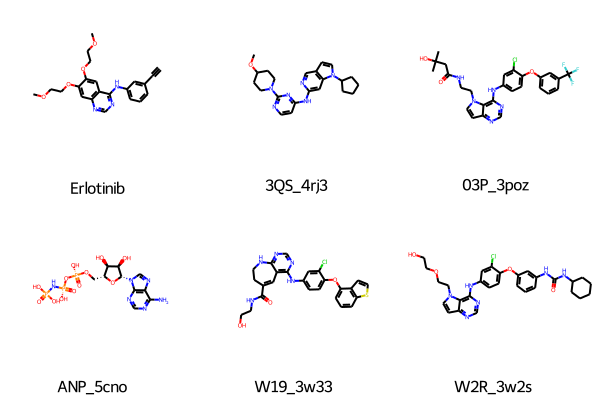

In [6]:
molecules = [Chem.MolFromSmiles(s) for s in smiles]
Draw.MolsToGridImage(molecules, legends=names)

#### Find most similiar compound - which one is the most similar one to Erlotinib?

In [7]:
reference_smile = smiles[0]
reference_name = names[0]

#define reference
print("Reference:", reference_name)
reference_molecule = Chem.MolFromSmiles(reference_smile)
reference_morgan_fp = AllChem.GetMorganFingerprint(reference_molecule, radius=2)
    
highest_similarity = 0
highest_name = "N/A"

# loop over all molecules

for smi, name in zip(smiles[1:], names[1:]):  # skip first (reference)
    molecule = Chem.MolFromSmiles(smi)
    morgan_fp = AllChem.GetMorganFingerprint(molecule, radius=2)
    dice_similarity = DataStructs.DiceSimilarity(reference_morgan_fp, morgan_fp)
    
    print(f"Similarity with {name}: {dice_similarity:4.2f}")
    
    # Check for best performer
    if reference_smile != smi and dice_similarity > highest_similarity:
        highest_name = name
        highest_similarity = dice_similarity
            
print(f"Most similar compound: {highest_name} with {highest_similarity:.2f}")

Reference: Erlotinib
Similarity with 3QS_4rj3: 0.27
Similarity with 03P_3poz: 0.44
Similarity with ANP_5cno : 0.18
Similarity with W19_3w33: 0.41
Similarity with W2R_3w2s: 0.45
Most similar compound: W2R_3w2s with 0.45


### Add descriptor column to dataframe

In [8]:
from rdkit.Chem import Descriptors
df["HeavyAtoms"] = df.apply(lambda x: Descriptors.HeavyAtomCount(Chem.MolFromSmiles(x['Smiles'])), axis=1)

In [9]:
df.head()

,Smiles,Name,HeavyAtoms
0,COCCOc1cc2c(cc1OCCOC)ncnc2Nc3cccc(c3)C#C,Erlotinib,29
1,COC1CCN(CC1)c1nccc(Nc2cc3n(ccc3cn2)C2CCCC2)n1,3QS_4rj3,29
2,CC(C)(O)CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc(c4)...,03P_3poz,38
3,Nc1ncnc2n(cnc12)[C@@H]1O[C@H](CO[P@@](O)(=O)O[...,ANP_5cno,31
4,OCCNC(=O)C1=Cc2c(Nc3ccc(Oc4cccc5sccc45)c(Cl)c3...,W19_3w33,35


### Statistics per column

In [10]:
df.HeavyAtoms.mean()

33.666666666666664

In [11]:
# You will need this syntax when the name of the column has spaces or other invalid attribute name characters
df["HeavyAtoms"].mean()

33.666666666666664

### Plotting information directly from column

<AxesSubplot:>

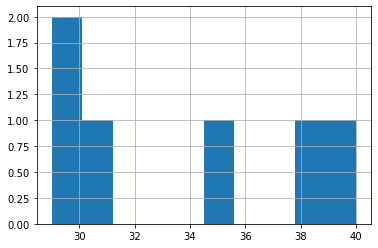

In [12]:
df.HeavyAtoms.hist()

### Soting df by column values

In [13]:
df.sort_values(["HeavyAtoms"], ascending=True, inplace=True)
df.head()

,Smiles,Name,HeavyAtoms
0,COCCOc1cc2c(cc1OCCOC)ncnc2Nc3cccc(c3)C#C,Erlotinib,29
1,COC1CCN(CC1)c1nccc(Nc2cc3n(ccc3cn2)C2CCCC2)n1,3QS_4rj3,29
3,Nc1ncnc2n(cnc12)[C@@H]1O[C@H](CO[P@@](O)(=O)O[...,ANP_5cno,31
4,OCCNC(=O)C1=Cc2c(Nc3ccc(Oc4cccc5sccc45)c(Cl)c3...,W19_3w33,35
2,CC(C)(O)CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc(c4)...,03P_3poz,38


### Substructure Search

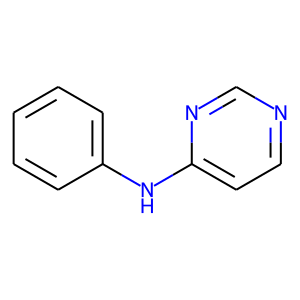

In [14]:
substructure_query = Chem.MolFromSmiles("c1c(Nc2ccccc2)ncnc1")
Chem.Draw.MolToImage(substructure_query)

In [15]:
submolecules = [molecule for molecule in molecules if molecule.HasSubstructMatch(substructure_query)]
print(len(submolecules), "matches out of", len(molecules))

4 matches out of 6


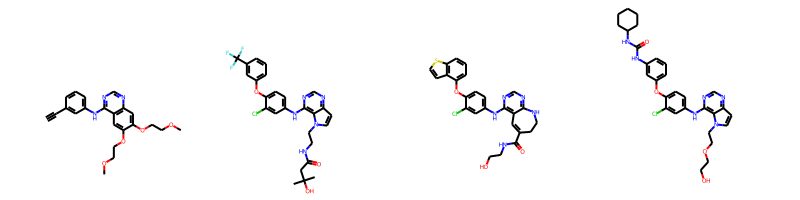

In [16]:
AllChem.Compute2DCoords(substructure_query)
for submolecule in submolecules: 
    AllChem.GenerateDepictionMatching2DStructure(submolecule, substructure_query)
Draw.MolsToGridImage(submolecules, molsPerRow=4)

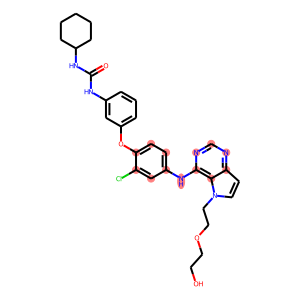

In [17]:
Chem.Draw.MolToImage(submolecules[-1], highlightAtoms=submolecules[-1].GetSubstructMatch(substructure_query))

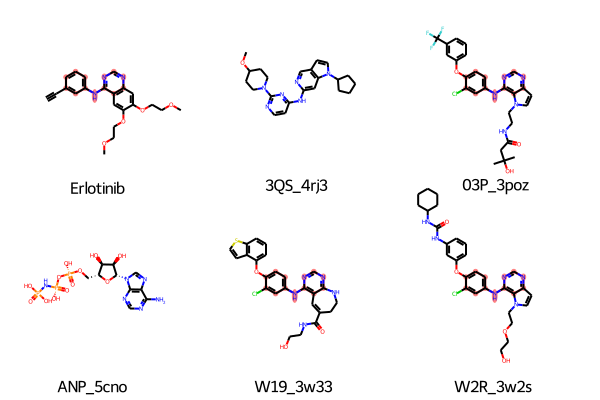

In [18]:
Draw.MolsToGridImage(molecules, highlightAtomLists=[molecule.GetSubstructMatch(substructure_query) for molecule in molecules], legends=names)